In [1]:
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
#import valis
import cv2

import seaborn as sns

175.0
42.0


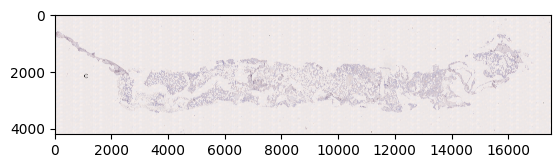

In [2]:
#get image mask

x_sc=100
y_sc=100

#make tiles
image = "b-ET-CALR-2021-02-19-11-12-00.ndpi"
#image = "b-ET-2021-02-08-12-25-45-CALR.ndpi"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/valis_slides/"

slide_path = os.path.join(filepath, image)

slide = open_slide(slide_path)

print(slide.level_dimensions[0][0]/512)
print(slide.level_dimensions[0][1]/512)

img = slide.get_thumbnail(((slide.level_dimensions[0][0]/512)*x_sc, (slide.level_dimensions[0][1]/512)*y_sc))
img = np.array(img)

plt.imshow(img)

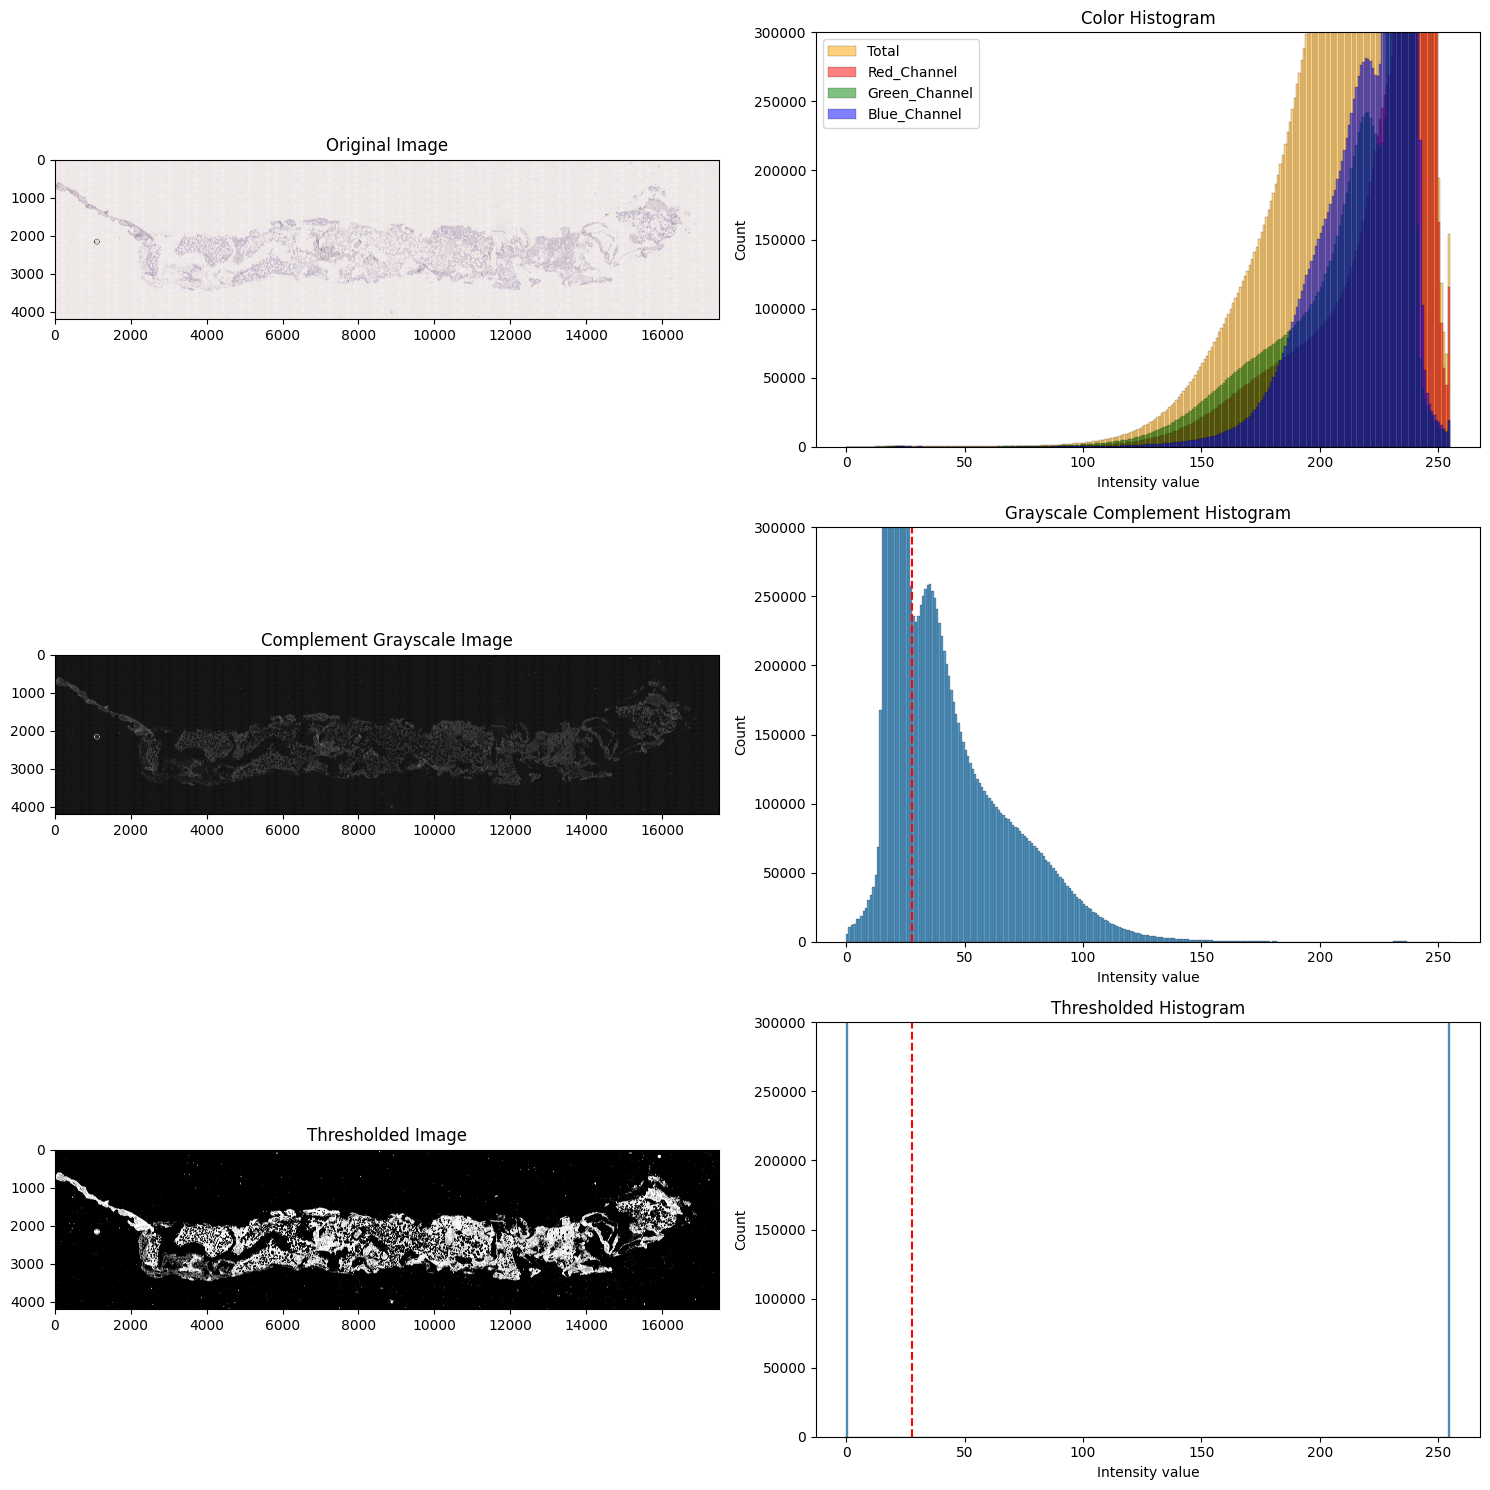

In [3]:
#https://www.kaggle.com/code/nghihuynh/wsi-preprocessing-tiling-tissue-segmentation
#apply otsu to get tissue mask

def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

def histogram(img, thres_img, img_c, thres):
    """
    style: ['color', 'grayscale']
    """ 
    plt.figure(figsize=(15,15))
    
    plt.subplot(3,2,1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(3,2,2)
    sns.histplot(img.ravel(), bins=np.arange(0,256), color='orange', alpha=0.5)
    sns.histplot(img[:,:,0].ravel(), bins=np.arange(0,256), color='red', alpha=0.5)
    sns.histplot(img[:,:,1].ravel(), bins=np.arange(0,256), color='Green', alpha=0.5)
    sns.histplot(img[:,:,2].ravel(), bins=np.arange(0,256), color='Blue', alpha=0.5)
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Color Histogram')
    
    plt.subplot(3,2,3)
    plt.imshow(img_c, cmap='gist_gray')
    plt.title('Complement Grayscale Image')
    
    plt.subplot(3,2,4)
    sns.histplot(img_c.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Grayscale Complement Histogram')
    
    plt.subplot(3,2,5)
    plt.imshow(thres_img, cmap='gist_gray')
    plt.title('Thresholded Image')
    
    plt.subplot(3,2,6)
    sns.histplot(thres_img.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Thresholded Histogram')
    
    plt.tight_layout()
    plt.show()

thres, thres_img, img_c = thresholding(img, method='triangle')
histogram(img, thres_img, img_c, thres)

In [6]:
#get the tiles which are tissue

#split thres im into tiles

# sx, sy = slide.dimensions
# ix, iy = thres_img.shape

# ratiox = sx/512
# ratioy = sy/512

M = x_sc
N = y_sc

new_M = int(M)/2
new_N = int(N)/2

print(new_M, new_N)

#https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python

tile_dict = {}
for x in range(0,thres_img.shape[0],int(new_M)):
    for y in range(0,thres_img.shape[1],int(new_N)):
        tile = thres_img[x:x+M,y:y+N]
        if tile.mean() > thres:
            tile_dict[(y/y_sc, x/x_sc)] = tile
        else:
            pass

print(thres_img.shape[0]/M)
print(thres_img.shape[1]/N)
print(slide.dimensions[0]/512)
print(slide.dimensions[1]/512)

50.0 50.0
42.0
175.0
175.0
42.0


127.0 23.0


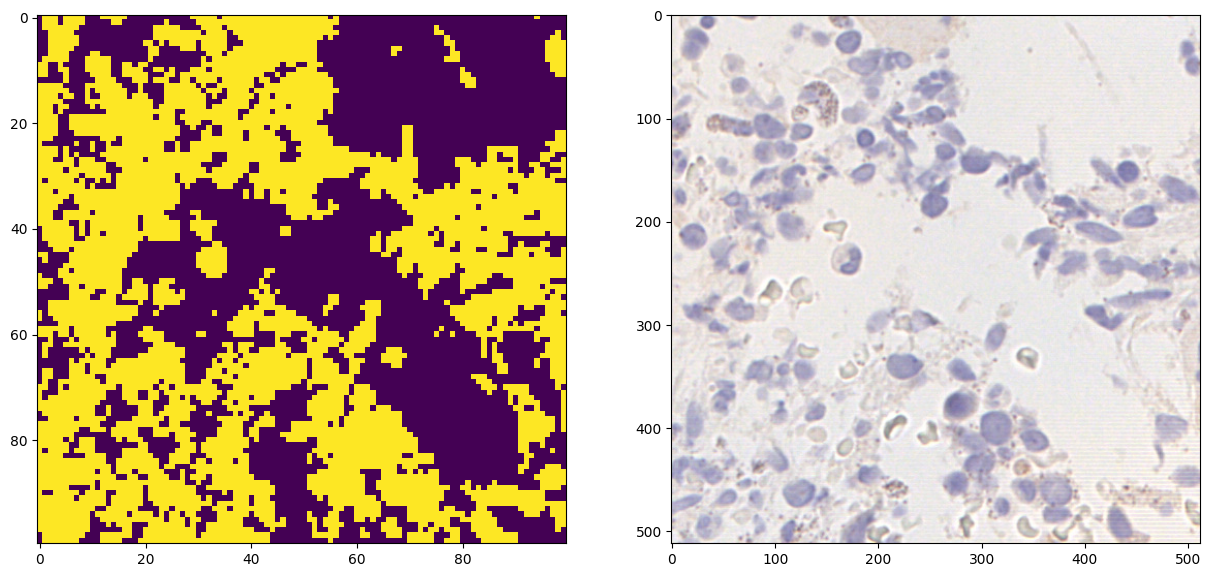

In [7]:
#plot tiles as subplots

fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs = axs.ravel()

key_list = list(tile_dict.keys())

#print(len(key_list))

#get random integer between 0 and length of key list
rand_num = np.random.randint(0, len(key_list))

tup = key_list[rand_num]

print(tup[0], tup[1])

axs[0].imshow(tile_dict[tup])
img = slide.read_region((int(512*tup[0]), int(512*tup[1])), 0, (512,512))
axs[1].imshow(img)

plt.show()


In [8]:
new_tile_dict = {}

for i in tile_dict.keys():
    col = int(i[0]*512)
    row = int(i[1]*512)
    new_tile_dict[(col, row)] = tile_dict[i]

In [9]:
new_coords = list(new_tile_dict.keys())

In [11]:
#make tiles
image = "b-ET-CALR-2021-02-19-11-12-00.ndpi"
im_name = "b-ET-CALR-2021-02-19-11-12-00"

tile_dir = "/well/rittscher/users/qdv200/MPN/GAN_tiles/extra_data/bET_ihc_tiles_for_ssd"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/valis_slides/"
slide = open_slide(os.path.join(filepath, image))

wsi_path = os.path.join(filepath, image)

try:
    to_unicode = unicode
except NameError:
    to_unicode = str

#MAKE IHC IMAGES
slide = openslide.open_slide(wsi_path)
patch_size = 512

for i in new_coords:
    col = int(i[0])
    row = int(i[1])
    tile_name = os.path.join(tile_dir, im_name + '_%d_%d' % (col, row))
    if not os.path.exists(os.path.join(tile_name + ".png")):
        print("Now saving tile with title: ", tile_name)
        img = slide.read_region(location=(col, row), level=0, size=(patch_size, patch_size))
        img = np.array(img)[:, :, 0:3]
        plt.imsave(tile_name + ".png", img)
    else: 
        continue




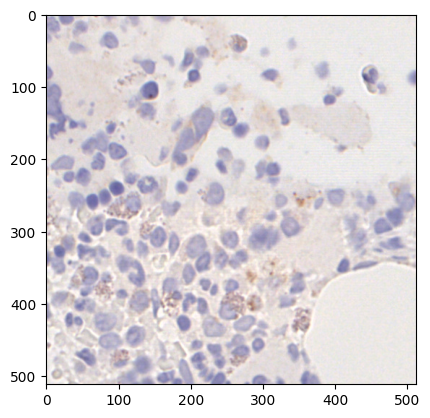

In [19]:
#get a rough look at the tiles in there
import random

files = os.listdir(tile_dir)

#choose random number in length of files

num = random.choice(range(0, len(files)))

img = plt.imread(os.path.join(tile_dir, files[num]))
plt.imshow(img)

In [ ]:
#convert these to he ima[ges
#apply the pretrained model

!python test.py --dataroot /well/rittscher/users/qdv200/MPN/GAN_tiles/extra_data/bET_ihc_tiles_for_ssd --name ihc2he_pretrained --model test --no_dropout --num_test 7220